In [1]:
from preprocessor import *
from recommender import *

import pandas as pd
import numpy as np

import networkx as nx
from stellargraph import StellarGraph
from stellargraph.mapper import Attri2VecNodeGenerator, GraphSAGENodeGenerator

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /Users/heidi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-05-19 15:18:45.550797: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nodes = pd.read_csv("data/nodes.csv")
nodes = nodes.set_index("Id")
alinks = pd.read_csv("data/alinks.csv")
# bilinks = pd.read_csv("data/bilinks.csv")
# clinks = create_clinks(bilinks,nodes)

## StellarGraphs

Stellargraph accepts only numerical features.

In [3]:
node_data = nodes[["Group","Salesrank","AvgRating"]]
GroupCodes = {'Book': 0, 'DVD': 1, 'Music': 2, 'Video': 3}
node_data["GroupCode"] = node_data["Group"].apply(lambda x: GroupCodes[x])
node_data = node_data[["GroupCode","Salesrank","AvgRating"]]
node_data.sample(3)

/var/folders/hk/kbn1q_sj4jz4lh0m7x05vff80000gn/T/ipykernel_10606/1441484520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_data["GroupCode"] = node_data["Group"].apply(lambda x: GroupCodes[x])


,GroupCode,Salesrank,AvgRating
Id,,,
523365,3,10069,3.5
90998,3,50428,0.0
100343,0,756184,0.0


**Homogeneous graph** where links represent the similar products and the similarity is taken from source data.

In [4]:
graph = StellarGraph({"product": node_data}, 
                            {"similar": alinks})
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 542664, Edges: 275230

 Node types:
  product: [542664]
    Features: float32 vector, length 3
    Edge types: product-similar->product

 Edge types:
    product-similar->product: [275230]
        Weights: all 1 (default)
        Features: none


## Attri2vec

1. Training the model:

In [5]:
x_inp_a2v, x_out_a2v, history_a2v, model_a2v = attri2vec_model(G=graph, 
                                                               batch_size=1000, 
                                                               epochs=1)

Generate samples ...
Attri2vec model ...
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Keras model ...
Train the model ...
3558/3558 [==============================] - 683s 192ms/step - loss: 0.7116 - binary_accuracy: 0.4938


2. Calculating node embeddings:

In [6]:
node_embeddings_a2v = generate_embeddings(features=node_data, 
                                          generator=Attri2VecNodeGenerator(G=graph, 
                                                                           batch_size=1000), 
                                          x_inp_src=x_inp_a2v[0], x_out_src = x_out_a2v[0])

543/543 [==============================] - 2s 4ms/step


3. Plotting the node embeddings on 2D:

<Figure size 504x504 with 0 Axes>

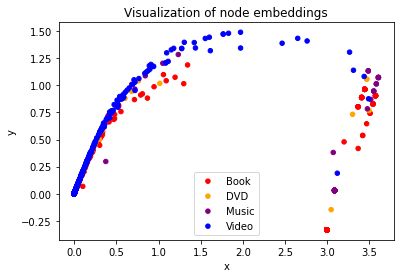

In [7]:
plot_embeddings(node_embeddings_a2v, node_data.GroupCode, PCA(n_components=2))

## GraphSAGE

1. Training the model:

In [8]:
x_inp_gs, x_out_gs, history_gs, model_gs = graphsage_model(G=graph,
                                                           batch_size=1000, 
                                                           epochs = 1)

Generate samples ...
GraphSAGE model ...
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Keras model ...
Train ...
3558/3558 [==============================] - 2959s 831ms/step - loss: 0.7285 - binary_accuracy: 0.5573


2. Calculating node embeddings:

In [9]:
node_embeddings_gs = generate_embeddings(features=node_data, 
                                         generator=GraphSAGENodeGenerator(G=graph, 
                                                                          batch_size=100, 
                                                                          num_samples=[5, 3]), 
                                         x_inp_src=x_inp_gs[0::2], x_out_src=x_out_gs[0])

5427/5427 [==============================] - 148s 27ms/step


3. Plotting nodes using PCA for feature reduction:

<Figure size 504x504 with 0 Axes>

/opt/anaconda3/envs/NS/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


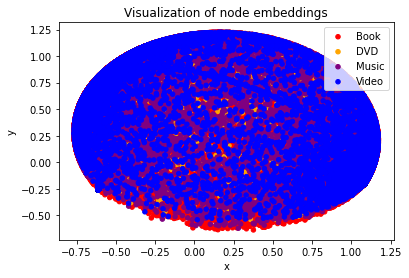

In [10]:
plot_embeddings(node_embeddings_gs,node_data.GroupCode,PCA(n_components=2))

4. Plotting nodes using TSNE for feature reduction (takes much more longer than PCA):

/opt/anaconda3/envs/NS/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/NS/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 504x504 with 0 Axes>

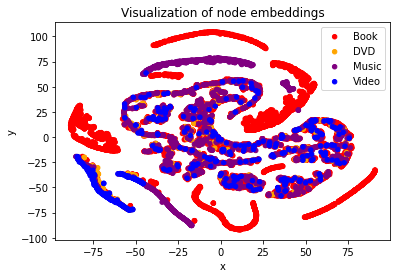

In [11]:
plot_embeddings(node_embeddings_gs[:10000,:], node_data.GroupCode.values[:10000],
                TSNE(n_components=2))

## Find recommendations
using embeddings and Nearest Neighbour algorithm

In [12]:
# embeddings to dataframe, index from the node attribute table which was used to create graph
X_GraphSAGE = pd.DataFrame(data=node_embeddings_gs,index=node_data.index)
X_Attri2vec = pd.DataFrame(data=node_embeddings_a2v,index=node_data.index)

Choosing 3 products which had the highest centrality values (see `GraphAnalysis.ipynb`)

In [33]:
sample_products = [548091,239107]

Finding recommendations for selected products:

In [34]:
metrics = ['minkowski','manhattan','canberra']
embs = {"GraphSAGE": X_GraphSAGE,"Attri2vec": X_Attri2vec} # GraphSAGE, Attri2vec
for product in sample_products:
    for emb in embs: 
        for metric in metrics:
            print(product, f"{nodes.loc[product,'Group']} '{nodes.loc[product,'Title']}':")
            print(f"{emb} embeddings: distance metric {metric}")
            recoms_with_distances([product],
                                  no_recommendations=5, 
                                  embeddings_df=embs[emb], 
                                  nodes_df=nodes, 
                                  metric=metric)
            print("")
    

548091 DVD 'Laura':
GraphSAGE embeddings: distance metric minkowski
For product DVD 'Laura' we recommend: 
1. DVD 'Michiganfest 2002': 0.0
2. Book 'Cajun Sexy Cookin'': 0.0002455619687680155
3. Book 'Introducing Wittgenstein': 0.0003080671012867242
4. Video 'The Blue Kite': 0.0003361192357260734
5. Book 'David Hare: Plays 1 : Slag, Teeth 'n' Smiles, Knuckle, Licking Hitler, Plenty (Contemporary Classics (Faber & Faber))': 0.0003379038244020194

548091 DVD 'Laura':
GraphSAGE embeddings: distance metric manhattan
For product DVD 'Laura' we recommend: 
1. DVD 'Michiganfest 2002': 0.0
2. Book 'Cajun Sexy Cookin'': 0.001117765554226935
3. Music 'Raspberry Jams': 0.0014050054596737027
4. Book 'Introducing Wittgenstein': 0.0014529192121699452
5. Video 'The Blue Kite': 0.0014841441297903657

548091 DVD 'Laura':
GraphSAGE embeddings: distance metric canberra
For product DVD 'Laura' we recommend: 
1. DVD 'Michiganfest 2002': 0.0
2. Book 'Cajun Sexy Cookin'': 0.008546216479484706
3. Video 'The Bl

## Similarities based on product graph

Defining the product-product graph with Amazon's similarity links:

In [35]:
G = nx.from_pandas_edgelist(alinks, source='source', target='target')
missing_nodes = list(set(nodes.index)-set(G.nodes()))
len(missing_nodes)
G.add_nodes_from(missing_nodes)

Reporting the similarities of the 3 selected products:

In [43]:
node_ids = list(G.nodes())
similarity = pd.DataFrame(index=node_ids)
for product in sample_products:
    # adamics = [list(nx.adamic_adar_index(G,[(product,idx)]))[0][2] for idx in node_ids]
    jaccards = [list(nx.jaccard_coefficient(G,[(product,idx)]))[0][2] for idx in node_ids]
    pref_att = [list(nx.preferential_attachment(G,[(product,idx)]))[0][2] for idx in node_ids]
    # similarity[f'{product}_adamics'] = adamics 
    similarity[f'{product}_jaccards'] = jaccards
    similarity[f'{product}_prefatts'] = pref_att
print_sim_products(nodes_df=nodes, similarity_df=similarity, max_similars=20)

Product DVD 'Laura':
Metric jaccards: 
1. DVD 'Laura': 1.0
2. DVD 'Carnival Story': 0.011494252873563218
3. Book 'The Ghost and Mrs. Muir': 0.011494252873563218
4. DVD 'The Strange Love of Martha Ivers / Kirk Douglas on Film - A Biography': 0.011494252873563218
5. DVD 'The Strange Love of Martha Ivers': 0.011494252873563218
6. DVD 'The Strange Love Of Martha Ivers': 0.011494252873563218
7. DVD 'Wanted for Murder': 0.011494252873563218
8. DVD 'Mademoiselle': 0.011494252873563218
9. Video 'Mississippi Mermaid': 0.011494252873563218
10. Video 'Beloved Infidel': 0.011494252873563218
11. DVD 'Cloak and Dagger': 0.011494252873563218
12. DVD 'Hangmen Also Die!': 0.011494252873563218
13. Video 'Cloak and Dagger': 0.011494252873563218
14. Video 'The Fireball': 0.011494252873563218
15. Video 'Ladies of the Chorus': 0.011494252873563218
16. Video 'Last Holiday': 0.011494252873563218
17. DVD 'Mississippi Mermaid': 0.011494252873563218
18. Video '5 Fingers': 0.011363636363636364
19. DVD 'Devil Doll